In [3]:
%load_ext autoreload
%autoreload 2
import sys; 
sys.path.append('../../')
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from datetime import date, time, datetime
from sklearn.metrics import f1_score
import copy
import plotly
import pickle
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from skimage import io
from src.model.dataset import VoronoiRegionDataset
from sklearn.model_selection import train_test_split
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0
DEVICE
torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#limit = 100
limit = None
BATCH_SIZE = 20
IMG_SHAPE = [244,244]

In [5]:
train_root = r"../../dl/train"
assert os.path.exists(train_root)
test_root = r"../../dl/test-voronoi"
assert os.path.exists(train_root)

In [6]:
train_dataset = VoronoiRegionDataset(train_root,limit)
targets_train = train_dataset.labels
test_dataset = VoronoiRegionDataset(test_root,limit)
targets_test = test_dataset.labels

In [7]:
targets_test

,Unnamed: 0,filename,label
0,0,p10_0035_9_0.jpg,1
1,0,p10_0035_9_1.jpg,1
2,0,p10_0035_9_2.jpg,2
3,0,p10_0035_9_3.jpg,2
4,0,p10_0036_3_0.jpg,2
...,...,...,...
33230,0,p9_0245_6_15.jpg,2
33231,0,p9_0245_6_16.jpg,2
33232,0,p9_0245_6_17.jpg,2
33233,0,p9_0245_6_18.jpg,1


In [8]:
targets_train

,Unnamed: 0,filename,label
0,0,p10_0031_5_0.jpg,1
1,0,p10_0031_5_1.jpg,3
2,0,p10_0031_5_2.jpg,3
3,0,p10_0031_5_3.jpg,3
4,0,p10_0031_5_4.jpg,3
...,...,...,...
236140,0,p9_0245_7_169.jpg,3
236141,0,p9_0245_7_170.jpg,3
236142,0,p9_0245_7_171.jpg,3
236143,0,p9_0245_7_172.jpg,3


In [9]:
train_dataset.__len__()

236145

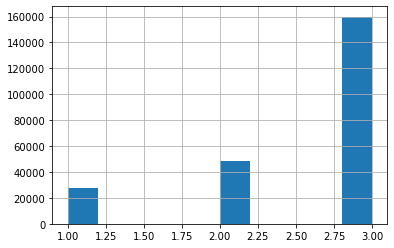

In [10]:
x = train_dataset.__getlabels__().label.hist()

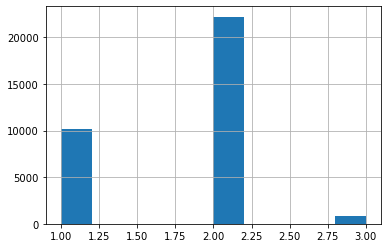

In [11]:
x_1 = test_dataset.__getlabels__().label.hist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


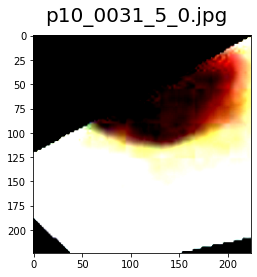

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


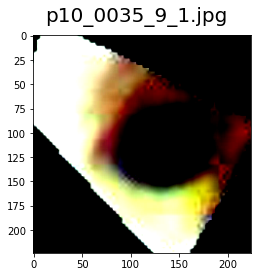

In [14]:
#train_idx, valid_idx= train_test_split(np.arange(len(targets.label)),test_size=0.2,shuffle=True,stratify=targets.label)
#train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
#valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
#train_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,sampler=train_sampler)
#test_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,sampler=valid_sampler)
train_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE)
train_dataset.plot(0)
test_dataset.plot(1)

In [18]:
print(train_dataset.__len__())
print(test_dataset.__len__())

236145
33235


In [19]:
from torchvision import datasets, models, transforms

In [20]:
NUM_CLASSES = train_dataset.__get_num_classes__()
model = models.densenet121(pretrained=True)

In [21]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)

In [22]:
model = model.to(DEVICE)


In [23]:
adam = optim.Adam(model.parameters(),lr=0.001)

In [24]:
loss_fnc = nn.CrossEntropyLoss()

In [25]:
dataloaders = {
    'train':train_dataloader,
    'val': test_dataloader
}

In [26]:
def train(model,dataloaders,loss_fnc,optim,epochs):
    logspath = os.path.join('logs',filename)
    writer = SummaryWriter(log_dir=logspath)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_fscore = 0.0
    for epoch in tqdm(range(epochs)):
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            fscore_epoch = []
            for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                    #print(inputs.shape)
                    optim.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = loss_fnc(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optim.step()
                    running_loss += loss.cpu().item() * inputs.size(0)
                    #
                    running_corrects += torch.sum(preds == labels.data).cpu()
                    predicted_numpy = preds.cpu()
                    predicted_numpy = predicted_numpy.numpy()
                    fscore_epoch.append(f1_score(y_true=labels.cpu().data,y_pred=predicted_numpy,average='macro'))
                    
            epoch_acc = running_corrects/ len(dataloaders[phase].dataset)
            loss_epoch = running_loss/ len(dataloaders[phase].dataset)
            fscore_epoch = sum(fscore_epoch) / len(fscore_epoch)
            writer.add_scalar('Loss/'+phase, loss_epoch, epoch)
            #history['loss_'+phase].append()
            writer.add_scalar('acc/'+phase, epoch_acc, epoch)
            #history['acc_'+phase].append(epoch_acc)
            writer.add_scalar('fscore/'+phase, fscore_epoch, epoch)
            #history['fscore_'+phase].append(fscore_epoch)
            if phase == 'val' and fscore_epoch > best_fscore:
                best_fscore = fscore_epoch
                best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    return model

In [27]:
date = datetime.now()
filename = 'densenet_'+str(date.date())+"start_at_time_"+str(date.time()).split('.')[0].replace(":","_")
model_trained = train(model,dataloaders,loss_fnc,adam,20)
#filename="densenet_mean.model"
torch.save(model_trained.state_dict(),filename)

 40%|██████████████████████████████▍                                             | 8/20 [9:22:44<14:04:06, 4220.54s/it]


KeyboardInterrupt: 

In [28]:
from sklearn.metrics import classification_report

In [29]:
MODEL_PATH = filename
model = models.densenet121(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
for phase in ['train','val']:
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(dataloaders[phase]):
        with torch.set_grad_enabled(False):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.append(preds.cpu().numpy())
            y_true.append(labels.cpu().data.numpy())
    print(f"*****{phase}*******")
    y_pred=  [item for sublist in y_pred for item in sublist]
    y_true=  [item for sublist in y_true for item in sublist]
    print(classification_report(y_true, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'densenet_2021-04-21start_at_time_11_43_23'